## Please look at "FinalProject_RealTime" file to understand the followiong code

the code can take model and train it on multiple different computer while store the gradient graph as a count sketch and convert it back into gradient graph to make a full backward propogation algorithm and than disterbut the new step into the whole system.


In [1]:
import random
import os
from os.path import join

import torch
import torch.nn as nn

import numpy as np
iterations = 30
localLossLs = []
disLossLs=[]

class VaultBasedOnCountSketch:

    def __init__(self, w: int, d: int):

        data = [[0 for _ in range(w)] for _ in range(d)]

        self.data = data
        self.w = w
        self.d = d

        self.index_str_to_hashs = {}
        self.index_str_to_positive_negative = {}

    def store_number(self, tensor_id: int, i_index: int, j_index: int, number_to_store: float, fixed_size: int = 8):

        index_str = str(tensor_id) + "_" + str(i_index) + "_" + str(j_index)

        if index_str not in self.index_str_to_hashs:
            self.index_str_to_hashs[index_str] = [hash(index_str * (i + 1)) for i in range(self.d)]
            self.index_str_to_positive_negative[index_str] = [1 if hash("min_" + (index_str * (i + 1))) % 2 else -1 for
                                                              i in range(self.d)]

        hashes = self.index_str_to_hashs[index_str]
        positivity = self.index_str_to_positive_negative[index_str]

        number_to_store = int(number_to_store * (10 ** fixed_size))

        for i in range(self.d):
            _hash = hashes[i]
            _positive = positivity[i]

            index = _hash % self.w

            self.data[i][index] += number_to_store * _positive

    def get_count_of_line(self, tensor_id: int, i_index: int, j_index: int, fixed_size: int = 8):

        arr = []
        for row in range(self.d):

            index_str = str(tensor_id) + "_" + str(i_index) + "_" + str(j_index)
            hashes = self.index_str_to_hashs[index_str][row]
            positivity = self.index_str_to_positive_negative[index_str][row]

            col = hashes % self.w
            arr.append((float(self.data[row][col] * positivity) / (10 ** fixed_size)))

        arr.sort()

        return arr[len(arr) // 2]

    

def get_vault(gradient, w, d):
    
    vault = VaultBasedOnCountSketch(w, d)

    for index, tensor_params in enumerate(gradient):

        params = tensor_params.tolist()
        size = len(tensor_params.shape)

        if size == 2:
            for i in range(tensor_params.shape[0]):

                for j in range(tensor_params.shape[1]):
                    vault.store_number(index, i, j, params[i][j])
        else:
            for i in range(tensor_params.shape[0]):
                vault.store_number(index, i, 0, params[i])


    return vault


def set_gradient(vault, gradient):
    
    for index, tensor_params in enumerate(gradient):

        params = tensor_params.tolist()
        size = len(tensor_params.shape)

        if size == 2:
            for i in range(tensor_params.shape[0]):

                for j in range(tensor_params.shape[1]):
                    tensor_params[i][j] = vault.get_count_of_line(index, i, j)
        else:
            for i in range(tensor_params.shape[0]):
                tensor_params[i] = vault.get_count_of_line(index, i, 0, )

                

def length_of_weight(weights):

    to_return = 1
    for s in weights.shape:
        to_return *= s
    return to_return


def set_item(weights_list, index_of_weight, index_in_weight_list, weight, index_in_weight):

    shape_size = len(weight.shape)

    if shape_size == 4:

        index_0 = index_in_weight % weight.shape[0]
        index_in_weight //= weight.shape[0]

        index_1 = index_in_weight % weight.shape[1]
        index_in_weight //= weight.shape[1]

        index_2 = index_in_weight % weight.shape[2]
        index_in_weight //= weight.shape[2]

        index_3 = index_in_weight % weight.shape[3]
        index_in_weight //= weight.shape[3]

        weight[index_0][index_1][index_2][index_3] = weights_list[index_0][index_1][index_2][index_3]

    elif shape_size == 2:

        index_0 = index_in_weight % weight.shape[0]
        index_in_weight //= weight.shape[0]

        index_1 = index_in_weight % weight.shape[1]
        index_in_weight //= weight.shape[1]

        weight[index_0][index_1] = weights_list[index_0][index_1]

    elif shape_size == 1:

        weight[index_in_weight] = weights_list[index_in_weight]

    else:
        raise Exception("not supported !!!")

    return 0 


def insert_weights(weights_list: list, model):

    weight_list_index = 0
    index_of_weight = 0

    model_data = model.state_dict()

    _index = 0
    for key, weight in model_data.items():

        weight = np.zeros(weight.shape)
        weight_index = 0
        length = length_of_weight(weight)

        for index in range(length):

           next_weight_needed = set_item(weights_list[_index],index_of_weight, weight_list_index,weight, weight_index)
           weight_index += 1
           weight_list_index += 1
           if next_weight_needed:
                index_of_weight += 1
                weight_list_index = 0

        model_data[key].cpu().detach()
        model_data[key] = torch.tensor(weight).cuda()

        _index += 1

    model.load_state_dict(model_data)
    
def get_model_weight_data(model):
    
    to_return = []
    
    for item in model.parameters():
        to_return.append(np.copy(item.detach().numpy()))


    return to_return


def get_gradient(steped_model, real_model):
    
    to_return = []
    
    for i in range(len(real_model)):
        
        to_return.append((real_model[i] - steped_model[i]))
        
    return to_return

def create_new_weight_based_on_gradient(model, gradient):
    
    to_return = []
    
    for i in range(len(model)):
        
        to_return.append(model[i] + gradient[i])
        
    return to_return
    
def multi_party_training(models, X, Y, number_of_computers):
    
    
    for iteration in range(iterations):
        
        vaults = []
        gradients = []
        
        # get current model poarams state
        # in every starting iteration all models should have the same weights params
        current_model_data = get_model_weight_data(models[0])
        
        # all different servers learning on thier own on thier private data and creating a vault
        for computer_index in range(number_of_computers):
            
            x = X[computer_index]
            y = Y[computer_index]
            model = models[computer_index]
            
            optim_base = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
            mse = nn.MSELoss()

            # Learning step process
            _y = model(x)
            loss = mse(_y, y)
            optim_base.zero_grad()
            loss.backward()
            optim_base.step()

            # get model state after one step
            steped_model_data = get_model_weight_data(model)

            # get gradient 
            gradient = get_gradient(current_model_data, steped_model_data)
            
            gradients.append(gradient)
            
            # create a vault
            vault = get_vault([np.copy(g).reshape(-1, 1) for g in  gradient] , w, d)
            
            # send my vault to the master server
            vaults.append(vault)
            
        # create new gradient based on all inputs
        
        for computer_index in range(number_of_computers):
            set_gradient(vaults[computer_index], [np.copy(g).reshape(-1, 1) for g in gradients[computer_index]])
        
        new_weight = create_new_weight_based_on_gradient(gradients[0], gradients[1])
        for computer_index in range(2, number_of_computers):
            new_weight = create_new_weight_based_on_gradient(new_weight, gradients[computer_index])
            
        for index in range(len(new_weight)):
            new_weight[index] /= number_of_computers
        
        # create new weight
        new_weight = create_new_weight_based_on_gradient(current_model_data, new_weight)
        
        # insert new weight to model
        for computer_index in range(number_of_computers):
            insert_weights(new_weight, models[computer_index])

        total_loss = 0
        count = 0
        for X1, Y1 in test_loader:
    
            X1 = X1.cpu()
            Y1 = Y1.cpu()
    
            
            _Y = models[0](X1)
    
            Y1 = Y1.type(torch.float)
    
            loss = mse(_Y.view(-1, 1), Y1.view(-1, 1))
            total_loss += loss.cpu().detach().numpy()
            count += 1
        disLossLs.append(total_loss/count)
        print("Train iter " , iteration, " - loss ", total_loss/count)


In [2]:
def getLossFromTensor(t):
    strT = str(t)
    return float(strT.split('(')[1].split(',')[0])

## Load Data

In [3]:
import torchvision

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

c:\users\alon bar\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Model

In [4]:

class MNISTCNN(nn.Module):
    
    def __init__(self, ):
        super(MNISTCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 3, 3)
        self.dense1 = nn.Linear(1728, 1)
        
    
    def forward(self, x):
        
        x = x.view(-1, 1, 28, 28)
        
        data_length = x.shape[0]
        
        x = self.conv1(x)
        x = torch.tanh(self.conv2(x))
        x = x.view(data_length, -1)
        x = self.dense1(x)
        return x


## Real Train

In [5]:

model = MNISTCNN().cuda()

for iteration in range(iterations):
    
    optim_base = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    mse = nn.MSELoss()
    
    total_loss = 0
    count = 0
    for X, Y in train_loader:
        
        X = X.cuda()
        Y = Y.cuda()
        
        Y = Y.type(torch.float)
        
        _Y = model(X)
        loss = mse(_Y.view(-1, 1), Y.view(-1, 1))
        
        optim_base.zero_grad()
        loss.backward()
        optim_base.step()
        
        total_loss += loss.cpu().detach().numpy()
        count += 1
    
    total_loss /= count
    localLossLs.append(total_loss)
        
    print("Train iter " , iteration, " - loss ", total_loss)


Train iter  0  - loss  2.8218742274780517
Train iter  1  - loss  1.837824614126799
Train iter  2  - loss  1.6735266454057145
Train iter  3  - loss  1.606298978394791
Train iter  4  - loss  1.5664583109716363
Train iter  5  - loss  1.535432833789
Train iter  6  - loss  1.5198616913513843
Train iter  7  - loss  1.5043163068894385
Train iter  8  - loss  1.4894447113150981
Train iter  9  - loss  1.4788983765441472
Train iter  10  - loss  1.4660612233539125
Train iter  11  - loss  1.4571416485728994
Train iter  12  - loss  1.4576856755752807
Train iter  13  - loss  1.4496446959753788
Train iter  14  - loss  1.4373860266417073
Train iter  15  - loss  1.4412285801190048
Train iter  16  - loss  1.4303338199790352
Train iter  17  - loss  1.4260804115582122
Train iter  18  - loss  1.4217862821082825
Train iter  19  - loss  1.4207552124315233
Train iter  20  - loss  1.4171709555552712
Train iter  21  - loss  1.4144722910196796
Train iter  22  - loss  1.4119370460256075
Train iter  23  - loss  1.4

In [6]:

total_loss = 0
count = 0
for X, Y in test_loader:
    
    X = X.cuda()
    Y = Y.cuda()
    
    # Learning step process
    _Y = model(X)
    
    Y = Y.type(torch.float)
    
    loss = mse(_Y.view(-1, 1), Y.view(-1, 1))
    total_loss += loss.cpu().detach().numpy()
    count += 1
    
print("Test Loss ", total_loss / count)

Test Loss  1.3605161786079407


## Train by Sketch

In [7]:

number_of_computers = 10

models = [MNISTCNN() for i in range(number_of_computers)]

model_structure = models[0].state_dict()

for i in range(1, number_of_computers):
    models[i].load_state_dict(model_structure)
    

In [8]:

X = []
Y = []

for _X, _Y in train_loader:
    
    X.append(_X.cpu().detach().numpy())
    Y.append(_Y.cpu().detach().numpy())
    

In [9]:
X = torch.tensor(np.array(X[:-1]))
Y = torch.tensor(np.array(Y[:-1]))

In [10]:
X = X.view(-1, 1, 28, 28)
Y = Y.view(59968, 1)
Y = Y.type(torch.float)

In [11]:
new_x = []
new_y = []

for i in range(number_of_computers):
    new_x.append(X[500 * i : 500 * (i + 1)])
    new_y.append(Y[500 * i : 500 * (i + 1)])


In [12]:
w = 1000
d = 25
multi_party_training(models, new_x, new_y, number_of_computers)

Train iter  0  - loss  10.531477642059325
Train iter  1  - loss  13.477277374267578
Train iter  2  - loss  9.833106803894044
Train iter  3  - loss  12.095414543151856
Train iter  4  - loss  9.413469409942627
Train iter  5  - loss  11.231008529663086
Train iter  6  - loss  9.181741046905518
Train iter  7  - loss  10.47668285369873
Train iter  8  - loss  8.89275302886963
Train iter  9  - loss  9.872389698028565
Train iter  10  - loss  8.706700706481934
Train iter  11  - loss  9.429951095581055
Train iter  12  - loss  8.714105224609375
Train iter  13  - loss  8.982861137390136
Train iter  14  - loss  8.448656558990479
Train iter  15  - loss  9.033971405029297
Train iter  16  - loss  8.132242727279664
Train iter  17  - loss  9.076675128936767
Train iter  18  - loss  7.932400274276733
Train iter  19  - loss  8.916533184051513
Train iter  20  - loss  7.756306552886963
Train iter  21  - loss  8.995175838470459
Train iter  22  - loss  7.601884555816651
Train iter  23  - loss  8.948450469970703

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
30


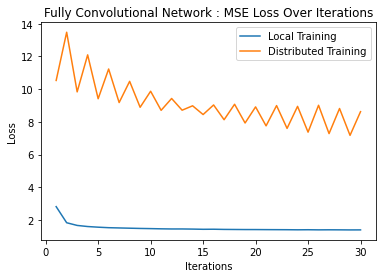

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
it = np.arange(1,iteration+2)
print(it)
print(len(localLossLs))
plt.plot(it,localLossLs,label = "Local Training")
plt.plot(it,disLossLs,label = "Distributed Training")
plt.title("Fully Convolutional Network : MSE Loss Over Iterations")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
